## summary

This notebook is to test one alpha with Leave one out run cross validation\n
* Reason behind this step: the correlations are all around 0.03. 
* At least, if we use the same alpha as Cara did with the LORO scheme, we should have similar correlations. 
* If not, we're kind of ready to abandon the tikreg algorithm. 
* But also worth checking how the results are outputted. 

# library

In [1]:
import matplotlib; matplotlib.use('agg')
import mvpa2.suite as mv
import numpy as np
import pandas as pd
from scipy import stats
from scipy.io import wavfile
import sys, os, time, csv
from sklearn.linear_model import RidgeCV
from nilearn.plotting import plot_surf
import matplotlib.pyplot as plt
from tikreg import models
from tikreg import utils as tikutils

from tikreg import models, utils as tikutils
from tikreg import spatial_priors, temporal_priors

import pickle


/Users/h/anaconda3/envs/pymvpa_env/lib/python2.7/site-packages/mvpa2/base/hdf5.py:40: H5pyDeprecationWarning: The h5py.highlevel module is deprecated, code should import directly from h5py, e.g. 'from h5py import File'.
  import h5py.highlevel  # >= 2.8.0, https://github.com/h5py/h5py/issues/1063
/Users/h/anaconda3/envs/pymvpa_env/lib/python2.7/site-packages/pydicom/__init__.py:55: DeprecationWarning: Python 2 will no longer be supported after the pydicom v1.4 release
  warnings.warn(msg, DeprecationWarning)
/Users/h/anaconda3/envs/pymvpa_env/lib/python2.7/site-packages/mvpa2/testing/tools.py:81: DeprecationWarning: Importing from numpy.testing.decorators is deprecated since numpy 1.15.0, import from numpy.testing instead.
  from numpy.testing.decorators import skipif
/Users/h/anaconda3/envs/pymvpa_env/lib/python2.7/site-packages/_pytest/mark/structures.py:383: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` 

In [2]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [7., 7.]
matplotlib.rcParams['font.size'] = 15


# directories

In [3]:
# directories ________________________________________________________________________________
# mvpa_dir = '/idata/DBIC/cara/life/pymvpa/'
# sam_data_dir = '/idata/DBIC/snastase/life'
# ridge_dir = '/idata/DBIC/cara/life/ridge'
# cara_data_dir = '/idata/DBIC/cara/life/data'
# npy_dir = '/idata/DBIC/cara/w2v/w2v_features'

# directories ________________________________________________________________________________
sam_data_dir = '/Users/h/Documents/projects_local/cluster_projects'
mvpa_dir = '/Users/h/Documents/projects_local/life-encoding/life/pymvpa'
npy_dir = '/Users/h/Documents/projects_local/life-encoding/w2v/w2v_features'

In [4]:
hemispheres = ['lh', 'rh']

tr_movie = {1:369, 2:341, 3:372, 4:406}
tr_fmri = {1:374, 2:346, 3:377, 4:412}
tr_length = 2.5
n_samples = 1509
n_vertices = 40962
n_proc = 32     # how many cores do we have?
n_medial = {'lh': 3486, 'rh': 3491}

# functions

In [5]:
def get_visual_stim_for_fold(stimfile, fold_shifted, included):
    cam = np.load(os.path.join(npy_dir, '{0}.npy'.format(stimfile)))
    # motion = np.load('/ihome/cara/global_motion/motion_downsampled_complete.npy')
    #
    # motion_list = []
    # motion_list.append(motion[:369])
    # motion_list.append(motion[369:710])
    # motion_list.append(motion[710:1082])
    # motion_list.append(motion[1082:])

    full_stim = []
    full_stim.append(cam[:369,:])
    full_stim.append(cam[369:710,:])
    full_stim.append(cam[710:1082,:])
    full_stim.append(cam[1082:,:])

    for i in range(len(full_stim)):
        # m = motion_list[i]
    	# m_avg = np.mean(np.vstack((m[3:], m[2:-1], m[1:-2], m[:-3])),axis=0)
    	# m_avg = np.reshape(m_avg,(-1,1))

        this = full_stim[i]
        # full_stim[i] = np.concatenate((m_avg, this[3:,:], this[2:-1,:], this[1:-2,:], this[:-3,:]), axis=1)
        full_stim[i] = np.concatenate((this[3:,:], this[2:-1,:], this[1:-2,:], this[:-3,:]), axis=1)

    train_stim = [full_stim[i] for i in np.subtract(included, 1)]
    test_stim = full_stim[fold_shifted-1]

    return train_stim, test_stim

In [6]:
def get_mel():
    mel_list = [[],[],[],[]]
    directory = os.path.join(cara_data_dir, 'spectral', 'complete')
    for f in os.listdir(directory):
        if 'csv' in f:
            run = int(f[-5])
            s = pd.read_csv(os.path.join(directory, f))
            filter_col = [col for col in s if col.startswith('mel')]
            tr_s = np.array(s[filter_col])
            tr_avg = np.mean(tr_s, axis=1)

            groupby = tr_avg.shape[0] / tr_movie[run]
            remainder = tr_avg.shape[0] % tr_movie[run]
            tr_reshaped = np.reshape(tr_avg[:-remainder], (tr_movie[run], groupby))
            avg = np.mean(tr_reshaped, axis=1)
            mel_list[run-1] = avg
    return mel_list

In [7]:
def get_ws_data(test_p, fold_shifted, included, hemi):
    print('\nLoading fMRI GIFTI data for HA in test subj space and using {0} as test participant...'.format(test_p))
    train_resp = []
    for run in included:
        avg = []
        if run == 4:
            resp = mv.gifti_dataset(os.path.join(sam_data_dir, '{0}_task-life_acq-{1}vol_run-0{2}.{3}.tproject.gii'.format(test_p, tr_fmri[run], run, hemi))).samples[4:-5,:]
        else:
            resp = mv.gifti_dataset(os.path.join(sam_data_dir, '{0}_task-life_acq-{1}vol_run-0{2}.{3}.tproject.gii'.format(test_p, tr_fmri[run], run, hemi))).samples[4:-4,:]

        resp = resp[:,cortical_vertices[hemi] == 1]
        mv.zscore(resp, chunks_attr=None)
        print('train', run, resp.shape)

        train_resp.append(resp)

    if fold_shifted == 4:
        test_resp = mv.gifti_dataset(os.path.join(sam_data_dir, '{0}_task-life_acq-{1}vol_run-0{2}.{3}.tproject.gii'.format(test_p, tr_fmri[fold_shifted], fold_shifted, hemi))).samples[4:-5,:]
    else:
        test_resp = mv.gifti_dataset(os.path.join(sam_data_dir, '{0}_task-life_acq-{1}vol_run-0{2}.{3}.tproject.gii'.format(test_p, tr_fmri[fold_shifted], fold_shifted, hemi))).samples[4:-4,:]

    test_resp = test_resp[:,cortical_vertices[hemi] == 1]
    mv.zscore(test_resp, chunks_attr=None)
    print('test', fold_shifted, test_resp.shape)

    return train_resp, test_resp

# sandbox parameters

In [9]:
model = 'visual'
align = 'ws'
stimfile1 = 'bg'
stimfile2 = 'actions'
fold = 1
fold_shifted = fold+1

hemi = 'lh'
# part = sys.argv[7]
# participant = []
# participant.append(part)
participants = ['sub-rid000001']
included = [1,2,3,4]
included.remove(fold_shifted)

# main code

In [10]:
cortical_vertices = {}
for half in ['lh', 'rh']:
    test_ds = mv.niml.read('/Users/h/Documents/projects_local/life-encoding-sandbox/niml/ws.lh.niml.dset'.format(half))
    cortical_vertices[half] = np.ones((n_vertices))
    cortical_vertices[half][np.sum(test_ds.samples[1:, :] != 0, axis=0) == 0] = 0

/Users/h/anaconda3/envs/pymvpa_env/lib/python2.7/site-packages/mvpa2/support/nibabel/afni_niml.py:182: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data_1d = np.fromstring(s, dtype=tp)


In [11]:
if model == 'visual':
    # stimfile1 = 'bg'
    X1train_stim, X1test_stim = get_visual_stim_for_fold('{0}_{1}'.format(model, stimfile1), fold_shifted, included)
    # stimfile2 = 'actions'
    X2train_stim, X2test_stim = get_visual_stim_for_fold('{0}_{1}'.format(model, stimfile2), fold_shifted, included)
    # train_stim, test_stim = get_visual_stim_for_fold('{0}_{1}'.format(model, stimfile), fold_shifted, included)
else:
    # stimfile1 = 'bg'
    X1train_stim, X1test_stim = get_narrative_stim_for_fold('{0}_{1}'.format(model, stimfile1), fold_shifted, included)
    # stimfile2 = 'actions'
    X2train_stim, X2test_stim = get_narrative_stim_for_fold('{0}_{1}'.format(model, stimfile2), fold_shifted, included)
    # train_stim, test_stim = get_narrative_stim_for_fold('{0}_{1}'.format(model, stimfile), fold_shifted, included)

In [11]:
np.array([18.33])

array([18.33])

# plot bands

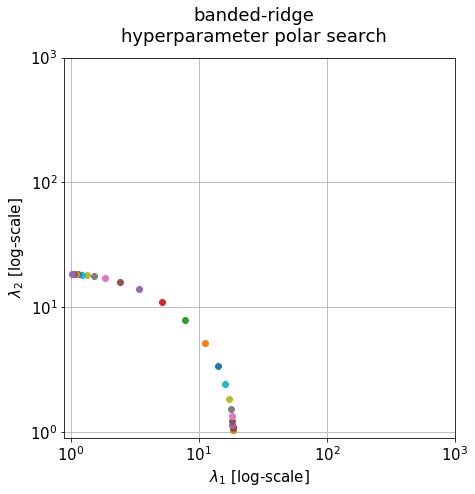

In [12]:
# Sampling in terms of ratios and scalings
alphas = np.array([18.33])
ratios = np.logspace(-2,2,25)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for ratio in ratios:
    angle = np.arctan(ratio)
    ypos = np.sin(angle)*np.log10(alphas)
    xpos = np.cos(angle)*np.log10(alphas)
    ax.plot(xpos, ypos, 'o-')

ax.set_xticks([0, 1, 2, 3], minor=False)
ax.set_yticks([0, 1, 2, 3], minor=False)
__ = ax.set_xticklabels(['$10^0$', '$10^1$', '$10^2$', '$10^3$'], fontsize=15)
__ = ax.set_yticklabels(['$10^0$', '$10^1$', '$10^2$', '$10^3$'], fontsize=15)

# Labels
ax.set_xlabel(r'$\lambda_1$ [log-scale]')
ax.set_ylabel(r'$\lambda_2$ [log-scale]')
__ = fig.suptitle('banded-ridge\nhyperparameter polar search')
ax.grid(True)

# features

In [13]:
for test_p in participants:
    if align == 'ws':
        Ytrain_unconcat, Ytest = get_ws_data(test_p, fold_shifted, included, hemi)
        # train_resp, test_resp = get_ws_data(test_p, fold_shifted, included, hemi)
    elif align == 'aa':
        Ytrain_unconcat, Ytest = get_aa_data(test_p, fold_shifted, included, hemi)
        # train_resp, test_resp = get_aa_data(test_p, fold_shifted, included, hemi)
    else:
        print('\nLoading hyperaligned mappers...')
        mappers = mv.h5load(os.path.join(mvpa_dir, 'search_hyper_mappers_life_mask_nofsel_{0}_leftout_{1}.hdf5'.format(hemi, fold_shifted)))
        if align == 'ha_common':
            Ytrain_unconcat, Ytest = get_ha_common_data(test_p, mappers, fold_shifted, included, hemi)
        elif align == 'ha_testsubj':
            Ytrain_unconcat, Ytest = get_ha_common_data(test_p, mappers, fold_shifted, included, hemi)

        # train_resp, test_resp = get_aa_data(test_p, fold_shifted, included, hemi)

    # concatenate 3 runs
    X1train = np.concatenate(X1train_stim)
    X2train = np.concatenate(X2train_stim)
    Ytrain = np.concatenate(Ytrain_unconcat)
    print('\nShape of training and testing set')
    print(X1train.shape, "X1train" )
    print(X2train.shape, "X2train")
    print(X1test_stim.shape, "X1test_stim")
    print(X2test_stim.shape, "X2test_stim")
    print(Ytest.shape, "Ytest")
    print(Ytrain.shape, "Ytrain")


Loading fMRI GIFTI data for HA in test subj space and using sub-rid000001 as test participant...


/Users/h/anaconda3/envs/pymvpa_env/lib/python2.7/site-packages/mvpa2/datasets/gifti.py:77: DeprecationWarning: giftiio.read function deprecated. Use nibabel.load() instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  samples = giftiio.read(samples)


('train', 1, (366, 37476))
('train', 3, (369, 37476))
('train', 4, (403, 37476))
('test', 2, (338, 37476))

Shape of training and testing set
((1138, 1200), 'X1train')
((1138, 1200), 'X2train')
((338, 1200), 'X1test_stim')
((338, 1200), 'X2test_stim')
((338, 37476), 'Ytest')
((1138, 37476), 'Ytrain')


In [17]:
for test_p in participants:
    if align == 'ws':
        Ytrain_unconcat, Ytest = get_ws_data(test_p, fold_shifted, included, hemi)
        # train_resp, test_resp = get_ws_data(test_p, fold_shifted, included, hemi)
    elif align == 'aa':
        Ytrain_unconcat, Ytest = get_aa_data(test_p, fold_shifted, included, hemi)
        # train_resp, test_resp = get_aa_data(test_p, fold_shifted, included, hemi)
    else:
        print('\nLoading hyperaligned mappers...')
        mappers = mv.h5load(os.path.join(mvpa_dir, 'search_hyper_mappers_life_mask_nofsel_{0}_leftout_{1}.hdf5'.format(hemi, fold_shifted)))
        if align == 'ha_common':
            Ytrain_unconcat, Ytest = get_ha_common_data(test_p, mappers, fold_shifted, included, hemi)
        elif align == 'ha_testsubj':
            Ytrain_unconcat, Ytest = get_ha_common_data(test_p, mappers, fold_shifted, included, hemi)

        # train_resp, test_resp = get_aa_data(test_p, fold_shifted, included, hemi)

    # concatenate 3 runs
    X1train = np.concatenate(X1train_stim)
    X2train = np.concatenate(X2train_stim)
    Ytrain = np.concatenate(Ytrain_unconcat)
    print('\nShape of training and testing set')
    print(X1train.shape, "X1train" )
    print(X2train.shape, "X2train")
    print(X1test_stim.shape, "X1test_stim")
    print(X2test_stim.shape, "X2test_stim")
    print(Ytest.shape, "Ytest")
    print(Ytrain.shape, "Ytrain")
    
#     alphas = np.logspace(0,3,20)
    alphas = np.array([18.33])
    ratios = np.logspace(-2,2,25)
    print('\nAlphas: np.logspace(18.33)')
    print('\nRatios: np.logspace(-2,2,25)')
    
    train_id = np.arange(X1train.shape[0])
    dur1, dur2, dur3 = tr_movie[included[0]]-3, tr_movie[included[1]]-3,tr_movie[included[2]]-3

    loro1 = [ (train_id[:dur1+dur2], train_id[dur1+dur2:]),
       ( np.concatenate((train_id[:dur1],train_id[dur1+dur2:]),axis=0),
         train_id[dur1:dur1+dur2]),
        (train_id[dur1:], train_id[:dur1])]

    X1_prior = spatial_priors.SphericalPrior(X1train, hyparams=ratios)
    X2_prior = spatial_priors.SphericalPrior(X2train, hyparams=ratios)
            # A temporal prior is unnecessary, so we specify no delays
    temporal_prior = temporal_priors.SphericalPrior(delays=[0]) # no delays

    fit_banded_polar = models.estimate_stem_wmvnp([X1train, X2train], Ytrain,
                                                          [X1test_stim, X2test_stim],Ytest,
                                                          feature_priors=[X1_prior, X2_prior],
                                                          temporal_prior=temporal_prior,
                                                          ridges=alphas,
                                                          folds=loro1,
                                                          performance=True,
                                                          weights=True,
                                                          verbosity=False)
    
    voxelwise_optimal_hyperparameters = fit_banded_polar['optima']
    print('\nVoxelwise optimal hyperparameter shape:', voxelwise_optimal_hyperparameters.shape)

#     primal_weights = []
#     for voxid, (temporal_lambda, lambda_one, lambda_two, alpha) in enumerate(voxelwise_optimal_hyperparameters):
#         ws = np.dot(np.hstack([X1/lambda_one**2, X2/lambda_two**2]).T, kernel_weights[:,voxid]*alpha)
#         primal_weights.append(ws)
#     primal_weights = np.asarray(primal_weights).T
#     print(primal_weights.shape)

    new_alphas = voxelwise_optimal_hyperparameters[:,-1]
    lambda_ones = voxelwise_optimal_hyperparameters[:,1]
    lambda_twos = voxelwise_optimal_hyperparameters[:,2]
    
    kernel_weights = fit_banded_polar['weights']
    # 1. estimated beta
    weights_x1 = np.linalg.multi_dot([X1train.T, kernel_weights, np.diag(new_alphas), np.diag(lambda_ones**-2)])
    # 2. multiply it with the X1test
#     predict_x1 = weights_x1*X1(annotation feature vectors for X1 TR)
    # 3. calculate the correlation Ytest
    
    # dimension ()
    #     weights_x1 = np.linalg.multi_dot([X1train.T, kernel_weights, np.diag(new_alphas), np.diag(lambda_ones**-2)])
    weights_x2 = np.linalg.multi_dot([X2train.T, kernel_weights, np.diag(new_alphas), np.diag(lambda_twos**-2)])
    weights_joint = np.vstack([weights_x1, weights_x2])
    print("\nFeature1 weight shape: ",weights_x1.shape)
    print("\nFeature2 weight shape: ",weights_x2.shape)
    print("\nJoint weights shape: ", weights_joint.shape)
    
    directory = os.path.join('/Users/h/Documents/projects_local/cluster_poker/scripts/jupyter_notebook/tikreg_output', '{0}/{1}/{2}_{3}/leftout_run_{4}'.format(align, model, stimfile1,stimfile2, fold_shifted), test_p, hemi)
    if not os.path.exists(directory):
        os.makedirs(directory)
    # SAVE WEIGHTS
    print("shape: ",weights_x1.shape)
    print("type: ",type(weights_x1))
    np.save(os.path.join(directory, 'kernel-weights_{0}_model-{1}_align-{2}_feature-{3}_foldshifted-{4}_hemi_{5}.npy'.format(test_p, model, align, stimfile1, fold_shifted, hemi)), weights_x1)
    np.save(os.path.join(directory, 'kernel-weights_{0}_model-{1}_align-{2}_feature-{3}_foldshifted-{4}_hemi_{5}.npy'.format(test_p, model, align, stimfile2, fold_shifted, hemi)), weights_x2)

    actual_df = pd.DataFrame(data = Ytest)
    estimated_x1 = pd.DataFrame(data = weights_x1)
    estimated_x2 = pd.DataFrame(data = weights_x2)
    corr_x1 = pd.DataFrame.corrwith(estimated_x1, actual_df, axis = 0, method = 'pearson')
    corr_x2 = pd.DataFrame.corrwith(estimated_x2, actual_df, axis = 0, method = 'pearson')




Loading fMRI GIFTI data for HA in test subj space and using sub-rid000001 as test participant...


/Users/h/anaconda3/envs/pymvpa_env/lib/python2.7/site-packages/mvpa2/datasets/gifti.py:77: DeprecationWarning: giftiio.read function deprecated. Use nibabel.load() instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  samples = giftiio.read(samples)


('train', 1, (366, 37476))
('train', 3, (369, 37476))
('train', 4, (403, 37476))
('test', 2, (338, 37476))

Shape of training and testing set
((1138, 1200), 'X1train')
((1138, 1200), 'X2train')
((338, 1200), 'X1test_stim')
((338, 1200), 'X2test_stim')
((338, 37476), 'Ytest')
((1138, 37476), 'Ytrain')

Alphas: np.logspace(18.33)

Ratios: np.logspace(-2,2,25)


/Users/h/anaconda3/envs/pymvpa_env/lib/python2.7/site-packages/tikreg/models.py:1222: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  unique_optima = np.vstack(set(tuple(row) for row in optima)) # get unique rows


('\nVoxelwise optimal hyperparameter shape:', (37476, 4))
('\nFeature1 weight shape: ', (1200, 37476))
('\nFeature2 weight shape: ', (1200, 37476))
('\nJoint weights shape: ', (2400, 37476))
('shape: ', (1200, 37476))
('type: ', <type 'numpy.ndarray'>)


# load pkl

In [14]:
pkl_file = open('/Users/h/Documents/projects_local/life_encoding_sub-01_fit_banded_polar.pkl', 'rb')
fit = pickle.load(pkl_file)
pkl_file.close()

In [23]:
kernel_weights = fit['weights']
voxelwise_optimal_hyperparameters = fit['optima']
new_alphas = voxelwise_optimal_hyperparameters[:,-1]
lambda_ones = voxelwise_optimal_hyperparameters[:,1]
lambda_twos = voxelwise_optimal_hyperparameters[:,2]
    # 1. estimated beta
weights_x1 = np.linalg.multi_dot([X1train.T, kernel_weights, np.diag(new_alphas), np.diag(lambda_ones**-2)])
print(weights_x1.shape, 'weights feature 1 background shape')
    # 2. multiply it with the X1test
#     predict_x1 = weights_x1*X1(annotation feature vectors for X1 TR)
predict_x1 = np.linalg.multi_dot([X1test_stim, weights_x1])
# (338, 1200), 'X1test_stim')
    # 3. calculate the correlation Ytest
sub01_corr = np.corrcoef(predict_x1, Ytest)

((1200, 37476), 'weights feature 1 background shape')


In [24]:
np.mean(sub01_corr)

0.08105662866614627

In [38]:
print(predict_x1.shape, "predict_x1 shape")
print(Ytest.shape, "Ytest shape")
print(sub01_corr.shape)

((338, 37476), 'predict_x1 shape')
((338, 37476), 'Ytest shape')
(676, 676)


correlation coefficient

In [39]:
actual_df = pd.DataFrame(data = Ytest)
estimated_x1 = pd.DataFrame(data = predict_x1)
# estimated_x2 = pd.DataFrame(data = weights_x2)
corr_x1 = pd.DataFrame.corrwith(estimated_x1, actual_df, axis = 0, method = 'pearson')
# corr_x2 = pd.DataFrame.corrwith(estimated_x2, actual_df, axis = 0, method = 'pearson')

In [40]:
print(corr_x1.shape)

(37476,)


# from notebook

In [9]:
nsamples = 1000
npfeatures = 100
nqfeatures = 200
nresponses = 100
X1 = np.random.randn(nsamples, npfeatures)
X2 = np.random.randn(nsamples, nqfeatures)
Ytrain = np.random.randn(nsamples, nresponses)
# Direct banded ridge solution
lambda_one = 30.0
lambda_two = 20.0

bands = np.asarray([lambda_one]*X1.shape[1] + [lambda_two]*X2.shape[1])
C = np.diag(bands)
Xjoint = np.hstack([X1, X2])

LH = np.linalg.inv(np.dot(Xjoint.T, Xjoint) + np.dot(C.T, C))
XTY = np.dot(Xjoint.T, Ytrain)
solution_direct_solution = np.dot(LH, XTY)

In [33]:
# Generate synthetic data
weights_true, (Xtrain, Xtest), (Ytrain, Ytest) = tikutils.generate_data(noise=1, testsize=100)
weights_true

array([[ 0.69414574, -0.5935907 ],
       [-1.07373603,  0.8798831 ],
       [ 1.83304638, -1.45443655],
       [-1.08304622, -0.42642727],
       [-0.75233931,  0.33543593],
       [ 1.97408909,  1.37988357],
       [ 0.51300906, -0.06778978],
       [ 0.71005546,  0.79606301],
       [ 1.71517091,  0.71257667],
       [-1.60429453,  1.82811584]])

In [19]:
fit_banded_polar['weights']

(1138, 37476)

In [22]:
bands = np.asarray([lambda_ones]*X1train.shape[1] + [lambda_twos]*X2train.shape[1])
Cinv = np.diag(bands**-1)


In [38]:
print(bands.shape, 'bands')
print(Cinv.shape, 'Cinv')
print(X1train.shape, 'X1train')
print(lambda_ones.shape, 'lambda_ones')
print(Ytrain.shape, 'Y1train')
print(fit_banded_polar['weights'].shape, 'fit_banded_polar weights')

((2400, 37476), 'bands')
((2400,), 'Cinv')
((1138, 1200), 'X1train')
((37476,), 'lambda_ones')
((100, 2), 'Y1train')
((1138, 37476), 'fit_banded_polar weights')


In [23]:
A = np.hstack([X1train/lambda_ones, X2train/lambda_twos])
U, S, VT = np.linalg.svd(A, full_matrices=False)
V = VT.T
UTY = np.dot(U.T, Ytrain)
D = np.diag(S / (S**2 + alphas**2))


ValueError: operands could not be broadcast together with shapes (1138,1200) (37476,) 

In [ ]:

solution_svd_standard = np.linalg.multi_dot([V, D, UTY])*alpha
solution_svd_bandstd2tik = np.dot(Cinv, solution_svd_standard)

In [ ]:
print(np.corrcoef(weights_x1.ravel(), sweights_x1.ravel())[0,1])

In [ ]:
    
    directory = os.path.join('/Users/h/Documents/projects_local/cluster_poker/scripts/jupyter_notebook/tikreg_output', '{0}/{1}/{2}_{3}/leftout_run_{4}'.format(align, model, stimfile1,stimfile2, fold_shifted), test_p, hemi)
    if not os.path.exists(directory):
        os.makedirs(directory)
    # SAVE WEIGHTS
    print("shape: ",weights_x1.shape)
    print("type: ",type(weights_x1))
    np.save(os.path.join(directory, 'kernel-weights_{0}_model-{1}_align-{2}_feature-{3}_foldshifted-{4}_hemi_{5}.npy'.format(test_p, model, align, stimfile1, fold_shifted, hemi)), weights_x1)
    np.save(os.path.join(directory, 'kernel-weights_{0}_model-{1}_align-{2}_feature-{3}_foldshifted-{4}_hemi_{5}.npy'.format(test_p, model, align, stimfile2, fold_shifted, hemi)), weights_x2)

    actual_df = pd.DataFrame(data = Ytest)
    estimated_x1 = pd.DataFrame(data = weights_x1)
    estimated_x2 = pd.DataFrame(data = weights_x2)
    corr_x1 = pd.DataFrame.corrwith(estimated_x1, actual_df, axis = 0, method = 'pearson')
    corr_x2 = pd.DataFrame.corrwith(estimated_x2, actual_df, axis = 0, method = 'pearson')



('shape: ', (1200, 37476))
('type: ', <type 'numpy.ndarray'>)


In [ ]:
sweights_x1 = solution_svd_standard[weights_x1]
sweights_x2 = solution_svd_standard[weights_x2]

print('Standard transform weights for X1:')
print(weights_x1[:1,:5])
print(sweights_x1[:1,:5])
print(np.corrcoef(weights_x1.ravel(), sweights_x1.ravel())[0,1])
print(np.allclose(weights_x1, sweights_x1))

print('Standard transform weights for X2:')
print(weights_x2[:1,:5])
print(sweights_x2[:1,:5])
print(np.corrcoef(weights_x2.ravel(), sweights_x2.ravel())[0,1])
print(np.allclose(weights_x2, sweights_x2))

assert np.allclose(weights_standard, solution_svd_standard)


# plot

In [26]:
surface_dir = '/Users/h/suma-fsaverage6'
sandbox_dir = '/Users/h/Documents/projects_local/life-encoding-sandbox'
fsaverage_gii_L = os.path.join(surface_dir ,  'lh.pial.gii')
fsaverage_gii_R = os.path.join(surface_dir , 'rh.pial.gii')
fsaverage_inflated_L = os.path.join(surface_dir , 'lh.inf_50.gii')
fsaverage_inflated_R = os.path.join(surface_dir , 'rh.inf_50.gii')


In [35]:
sub01_corr.shape

(676, 676)

In [42]:

med_wall_ind = np.where(cortical_vertices[hemi] == 0)[0]
out = np.zeros((corr_x1.shape[0]+med_wall_ind.shape[0]),dtype=np.dtype(corr_x1).type)
out[cortical_vertices[hemi] == 1] =corr_x1
mv.niml.write('/Users/h/Documents/projects_local/life-encoding-sandbox/tikreg_sandbox.niml.dset', out[None,:])


In [44]:
sub_file_name = os.path.join('/Users/h/Documents/projects_local/life-encoding-sandbox/tikreg_sandbox.niml.dset')
X1 = mv.niml.read(sub_file_name)


/Users/h/anaconda3/envs/pymvpa_env/lib/python2.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


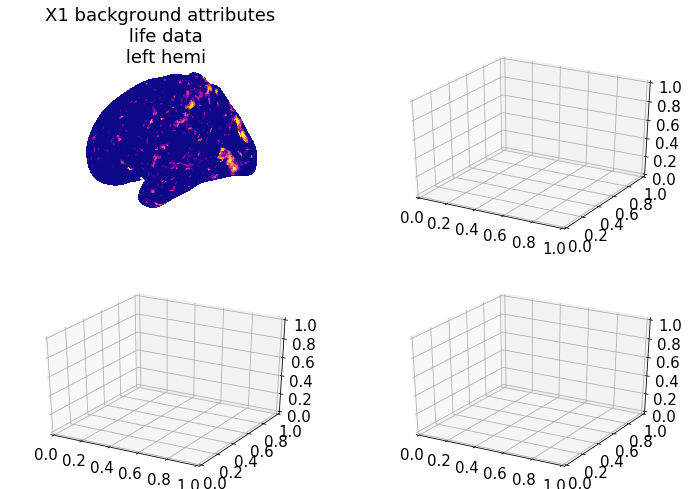

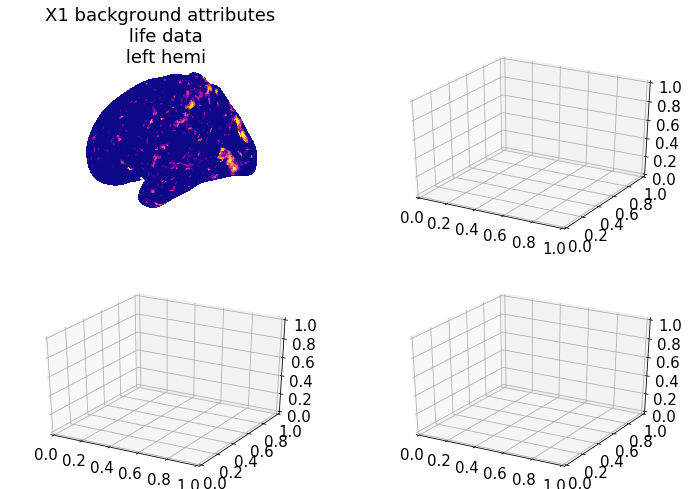

In [45]:
# f, axs = plt.subplots(2, 2)
figure, axes = plt.subplots(2,2,subplot_kw={'projection': '3d'},figsize = (12,8))
plot_surf(fsaverage_inflated_L,np.asarray(X1.samples[0]), 
          title='X1 background attributes \n life data\n left hemi', 
          hemi='left', view = 'lateral', vmin=.05, vmax=.20, cmap = 'plasma',axes=axes[0][0])
# plot_surf(fsaverage_gii_L,np.asarray(X2.samples[0]), colorbar = True,
#           title='X2 action attributes \n life data\n left hemi', 
#           hemi='left', view = 'lateral', vmin=.05, vmax=.20, cmap = 'plasma',axes=axes[0][1])
# # plot_surf(fsaverage_inflated_L,mean_cl20_taxtask_L, 